# Endogeneity

## Definition

Endogeneity occurs when the model's error term $\varepsilon_n$ is correlated with at least one explanatory variable $x^k_{n}$ in the specified model

$
\quad \text{cov}(\varepsilon_n, x^k_{n}) = E\big[\varepsilon_n, x^k_{n}\big] \neq 0
$

## In other words

$
\quad y = \beta_{pr} pr + \varepsilon
$

Price and unobservables are correlated. Parameter estimates are biased and inconsistent, i.e., coefficients are not interpretable and statistical inferences cannot be drawn.

## Example

Discounts are set according to shoppers' preferences.  For example, shoppers with a high purchase probability receive lower discounts and shoppers with lower purchase probabilities receive higher discounts. 

This notebook will look at a real-world example form a system for coupon personalization.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.rcParams.update(
    {
        "figure.figsize": (10, 8),
        "axes.titlesize": 15,
        "axes.labelsize": 11,
        "legend.fontsize": 11,
        "axes.grid": True,
        "axes.axisbelow": True,
    }
)

In [2]:
def train_model(formula, data):
    model = smf.glm(formula=formula, data=data, family=sm.families.Binomial())
    result = model.fit()
    print(result.summary())
    return model, result

## Load data

Two types of observations

1. `cohort_type == "t"`: ___Targeted___ coupon assignments
2. `cohort_type == "r"`: ___Random___ coupon assignments

The binary variable `conversion` identifies coupon conversions.

In [3]:
# it's not possible to share the data for this notebook
df_raw = pd.read_parquet(
    os.path.expanduser("~/Dropbox_RSM/teaching/big-data-22/data/coupons/coupons.parquet"),
    columns=["customer_id", "campaign_id", "conversion", "discount", "cs_customer_campaign", "cohort_type", "category_name"],
)
df_raw["cohort"] = df_raw["cohort_type"].map({"r": "random", "t": "targeted"})
df_raw.head()

,customer_id,campaign_id,conversion,discount,cs_customer_campaign,cohort_type,category_name,cohort
690124,140,3001463,0,0.33,0.2311,t,butter_margarine,targeted
5272144,140,3000770,0,0.40,0.1103,t,frozen_potato_products,targeted
5509424,140,3001504,0,0.10,0.3174,t,fresh_vegetables,targeted
6340851,140,3001501,0,0.35,0.1656,t,fresh_fruits,targeted
7446909,140,3001450,0,0.23,0.1546,t,coffee_filters,targeted


## Sample data

In [4]:
np.random.seed(1234)
df = df_raw.copy()
df["_tmp"] = np.random.uniform(0, 1, df.shape[0])
df = df.sort_values("_tmp")
df_raw = df_raw.reset_index(drop=True)

df_t = df[df["cohort_type"] == "t"].head(20_000)
df_r = df[df["cohort_type"] == "r"].head(10_000)

df_mixed = pd.concat([df_t, df_r])  # combine random and targeted coupons

## Train models

In [5]:
df_mixed.head()

,customer_id,campaign_id,conversion,discount,cs_customer_campaign,cohort_type,category_name,cohort,_tmp
28160399,214781,3013768,0,0.38,0.0387,t,salty_snacks,targeted,2.155274e-08
16453710,509242,3009820,0,0.10,0.1433,t,soft_drinks,targeted,1.309428e-07
26683623,1492272,3012990,0,0.11,0.0999,t,cereal,targeted,1.328299e-07
7239297,24139,3000332,0,0.33,0.0503,t,cheese,targeted,1.542744e-07
2899055,458795,3000748,0,0.25,0.2156,t,juice,targeted,1.619950e-07


### Full data

In [6]:
model_f, res_f = train_model("conversion ~ discount", df_mixed)

                 Generalized Linear Model Regression Results                  
Dep. Variable:             conversion   No. Observations:                30000
Model:                            GLM   Df Residuals:                    29998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5484.6
Date:                Thu, 03 Nov 2022   Deviance:                       10969.
Time:                        22:31:52   Pearson chi2:                 3.01e+04
No. Iterations:                     6   Pseudo R-squ. (CS):           0.001401
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6220      0.070    -37.309      0.0

### Cohort `t`

In [7]:
model_t, res_t = train_model("conversion ~ discount", df_t)

                 Generalized Linear Model Regression Results                  
Dep. Variable:             conversion   No. Observations:                20000
Model:                            GLM   Df Residuals:                    19998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4311.0
Date:                Thu, 03 Nov 2022   Deviance:                       8622.0
Time:                        22:31:52   Pearson chi2:                 2.02e+04
No. Iterations:                     6   Pseudo R-squ. (CS):           0.008090
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8586      0.075    -24.840      0.0

### Cohort `r`

In [8]:
model_r, res_r = train_model("conversion ~ discount", df_r)

                 Generalized Linear Model Regression Results                  
Dep. Variable:             conversion   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -981.64
Date:                Thu, 03 Nov 2022   Deviance:                       1963.3
Time:                        22:31:52   Pearson chi2:                 9.95e+03
No. Iterations:                     7   Pseudo R-squ. (CS):           0.002079
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.6696      0.196    -23.773      0.0

## Plots preference scores vs. discounts

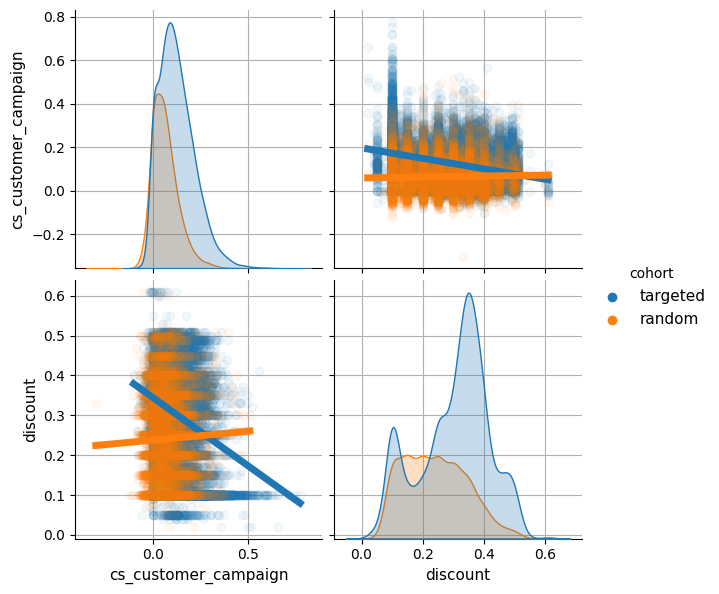

In [9]:
df_plot = df_mixed[(df_mixed["_tmp"] < 0.1)]

g = sns.pairplot(
    df_plot,
    vars=["cs_customer_campaign", "discount"],
    height=3,
    kind="reg",
    hue="cohort",
    plot_kws={
        "scatter_kws": {"alpha": 0.05},
        "line_kws": {"linewidth": 5},
    },
    diag_kws={"bw_adjust": 1.5},
)
for lh in g._legend.legendHandles:
    lh.set_alpha(1)

plt.show()

## Price (discount) elasticities

In [10]:
df_t_full = df[df["cohort"] == "targeted"].reset_index(drop=True)
df_t_full["p"] = res_t.predict(df_t_full)
df_t_full["eta"] = -(
    res_t.params["discount"] * (1 - df_t_full["discount"].values) * (1 - df_t_full["p"])
)

In [11]:
df_r_full = df[df["cohort_type"] == "r"].reset_index(drop=True)
df_r_full["p"] = res_r.predict(df_r_full)
df_r_full["eta"] = -(
    res_r.params["discount"] * (1 - df_r_full["discount"].values) * (1 - df_r_full["p"])
)

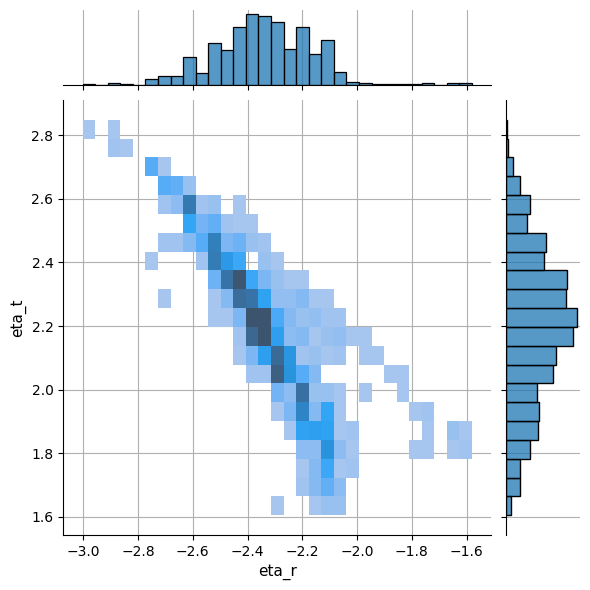

In [12]:
eta_c_r = df_r_full.groupby("campaign_id")[["eta"]].mean()
eta_c_t = df_t_full.groupby("campaign_id")[["eta"]].mean()
eta_c = eta_c_r.merge(eta_c_t, on="campaign_id", suffixes=["_r", "_t"])

g = sns.jointplot(
    data=eta_c,
    x="eta_r",
    y="eta_t",
    kind="hist",
)

plt.show()

<br>
<br>
<b>Learning from Big Data</b> <br>
Sebastian Gabel <br>